# Tabular Binary Classification (Beginner)

> Introducing the Tabular API with an example problem

In [ ]:
#hide
from wwf.utils import *

In [ ]:
#hide_input
state_versions(['fastai', 'fastcore'])

---
This article is also a Jupyter Notebook available to be run from the top down. There will be code snippets that you can then run in any environment. Below are the versions of `fastai` and `fastcore` currently running at the time of writing this:
* `fastai`: 2.0.14 
* `fastcore`: 1.0.11 
---

## Binary Classification

In this example we will be walking through the `fastai` tabular API to perform binary classification on the Salary dataset.

This notebook can run along side the first tabular lesson from Walk with fastai2, shown [here](https://www.youtube.com/watch?v=liTHAhdl1cQ&list=PLFDkaGxp5BXDvj3oHoKDgEcH73Aze-eET&index=9&t=430s)

First we need to call the tabular module:

In [ ]:
from fastai.tabular.all import *

And grab our dataset:

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

If we look at the contents of our folder, we will find our data lives in `adult.csv`:

In [ ]:
path.ls()

(#3) [Path('/home/ml1/.fastai/data/adult_sample/models'),Path('/home/ml1/.fastai/data/adult_sample/export.pkl'),Path('/home/ml1/.fastai/data/adult_sample/adult.csv')]

We'll go ahead and open it in `Pandas` and take a look:

In [ ]:
df = pd.read_csv(path/'adult.csv')
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


## TabularPandas

`fastai` has a new way of dealing with tabular data by utilizing a `TabularPandas` object. It expects some dataframe, some `procs`, `cat_names`, `cont_names`, `y_names`, `y_block`, and some `splits`. We'll walk through all of them

First we need to grab our categorical and continuous variables, along with how we want to process our data.

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

When we pre-process tabular data with `fastai`, we do one or more of three transforms:

* `Categorify`
* `FillMissing`
* `Normalize`

### Categorify

`Categorify` will transform columns that are in your `cat_names` into that type, along with label encoding our categorical data. 


First we'll make an instance of it:

In [ ]:
cat = Categorify()

And now let's try transforming a dataframe

In [ ]:
to = TabularPandas(df, cat, cat_names)

We can then extract that transform from `to.procs.categorify`:

In [ ]:
cats = to.procs.categorify

Let's take a look at the categories:

In [ ]:
cats['relationship']

(#7) ['#na#',' Husband',' Not-in-family',' Other-relative',' Own-child',' Unmarried',' Wife']

We can see that it added a `#na# `category. Let's look at the actual column:

In [ ]:
to.show(max_n=3)

,workclass,education,marital-status,occupation,relationship,race
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White
1,Private,Masters,Divorced,Exec-managerial,Not-in-family,White
2,Private,HS-grad,Divorced,#na#,Unmarried,Black


We can see now, for example, that `occupation` got returned a `#na# `value (as it was missing)

If we call `to.cats` we can see our one-hot encoded variables:

In [ ]:
to.cats.head()

,workclass,education,marital-status,occupation,relationship,race
0,5,8,3,0,6,5
1,5,13,1,5,2,5
2,5,12,1,0,5,3
3,6,15,3,11,1,2
4,7,6,3,9,6,3


### Normalize

To properly work with our numerical columns, we need to show a relationship between them all that our model can understand. This is commonly done through Normalization, where we scale the data between -1 and 1, and compute a `z-score`

In [ ]:
norm = Normalize()

Let's make another `to`

In [ ]:
to = TabularPandas(df, norm, cont_names=cont_names)

In [ ]:
norms = to.procs.normalize

And take a closer look.

We can grab the means and standard deviations like so:

In [ ]:
norms.means

{'age': 38.58164675532078,
 'fnlwgt': 189778.36651208502,
 'education-num': 10.079815426825466}

In [ ]:
norms.stds

{'age': 13.64022319230403,
 'fnlwgt': 105548.3568809906,
 'education-num': 2.5729591440613078}

And we can also call `to.conts` to take a look at our transformed data:

In [ ]:
to.conts.head()

,age,fnlwgt,education-num
0,0.763796,-0.838084,0.746294
1,0.397233,0.444987,1.523609
2,-0.042642,-0.886734,NaN
3,-0.042642,-0.728873,1.912267
4,0.250608,-1.018314,NaN


### FillMissing

Now the last thing we need to do is take care of any missing values in our **continuous** variables (we have a special `#na#` for categorical data already). We have three strategies we can use:
* `median`
* `mode`
* `constant`

By default it uses `median`:

In [ ]:
fm = FillMissing(fill_strategy=FillStrategy.median)

We'll recreate another `TabularPandas`:

In [ ]:
to = TabularPandas(df, fm, cont_names=cont_names)

Let's look at those missing values in the first few rows:

In [ ]:
to.conts.head()

,age,fnlwgt,education-num
0,49,101320,12.0
1,44,236746,14.0
2,38,96185,10.0
3,38,112847,15.0
4,42,82297,10.0


**But wait!** There's more!

In [ ]:
to.cat_names

(#1) ['education-num_na']

We have categorical values?! Yes!

In [ ]:
to.cats.head()

,education-num_na
0,False
1,False
2,True
3,False
4,True



We now have an additional boolean value based on if the value was missing or not too!

## The DataLoaders

Now let's build our `TabularPandas` for classifying. We're also going to want to split our data and declare our `y_names` too:

In [ ]:
splits = RandomSplitter()(range_of(df))
splits

((#26049) [18724,19703,4062,9102,28824,4054,5833,16188,2731,28161...],
 (#6512) [24465,976,1726,10178,4740,3920,32288,26018,20274,9660...])

What is `range_of`?

In [ ]:
range_of(df)[:5], len(df)

([0, 1, 2, 3, 4], 32561)

It's a list of total index's in our `DataFrame`

We'll use all our `cat` and `cont` names, the `procs`, declare a `y_name`, and finally specify a single-label classification problem with `CategoryBlock`

In [ ]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'
y_block = CategoryBlock()

Now that we have everything declared, let's build our `TabularPandas`:

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, y_block=y_block, splits=splits)

And now we can build the `DataLoaders`. We can do this one of two ways, first just calling `to.dataloaders()` on our data:

In [ ]:
dls = to.dataloaders()

Or we can create the `DataLoaders` ourselves (a train and valid). One great reason to do this this way is we can pass in different batch sizes into each `TabDataLoader`, along with changing options like `shuffle` and `drop_last`

So how do we use it? Our train and validation data live in to.train and to.valid right now, so we specify that along with our options. When you make a training DataLoader, you want `shuffle` to be `True` and `drop_last` to be `True` (so we drop the last incomplete batch)


In [ ]:
trn_dl = TabDataLoader(to.train, bs=64, shuffle=True, drop_last=True)
val_dl = TabDataLoader(to.valid, bs=128)

Now we can make some `DataLoaders`:

In [ ]:
dls = DataLoaders(trn_dl, val_dl)

And show a batch of data:

In [ ]:
dls.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,11th,Never-married,Sales,Own-child,White,False,17.0,200199.000263,7.0,<50k
1,Private,HS-grad,Divorced,Exec-managerial,Not-in-family,White,False,36.0,256635.997971,9.0,<50k
2,Private,HS-grad,Married-civ-spouse,Transport-moving,Husband,White,False,44.0,172032.000108,9.0,<50k
3,Self-emp-not-inc,5th-6th,Married-civ-spouse,Craft-repair,Husband,White,False,44.0,112506.998184,3.0,<50k
4,Local-gov,Some-college,Never-married,Exec-managerial,Not-in-family,White,False,40.0,74949.002528,10.0,<50k
5,?,10th,Never-married,?,Own-child,White,False,17.0,138506.999270,6.0,<50k
6,Private,Assoc-voc,Married-civ-spouse,Prof-specialty,Wife,White,False,28.0,247819.002902,11.0,<50k
7,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,False,37.0,112496.998941,14.0,>=50k
8,Private,HS-grad,Separated,Handlers-cleaners,Not-in-family,Black,False,41.0,215479.000444,9.0,<50k
9,Private,Assoc-voc,Divorced,Sales,Own-child,White,False,31.0,163302.999641,11.0,<50k


> Why can we do the `.dataloaders()`? Because `TabularPandas` itself is actually a set of `TabDataLoaders`! See below for a comparison test:

In [ ]:
to._dbunch_type == dls._dbunch_type

True

## Tabular Learner and Training a Model

Now we can build our `Learner`! But what's special about a tabular neural network?

### Categorical Variables

When dealing with our categorical data, we create what is called an **embedding matrix**. This allows for a higher dimentionality for relationships between the different categorical cardinalities. Finding the best size ratio was done through experiments by Jeremy on the Rossmann dataset

This "rule of thumb" is to use either a maximum embedding space of 600, or 1.6 times the cardinality raised to the 0.56, or written out as:

$$min(600, (1.6 * {var.nunique)}^{0.56})$$

Let's calculate these embedding sizes for our model to take a look-see:

In [ ]:
emb_szs = get_emb_sz(to); emb_szs

[(10, 6), (17, 8), (8, 5), (16, 8), (7, 5), (6, 4), (3, 3)]


If we want to see what each one aligns to, let's look at the order of `cat_names`

In [ ]:
to.cat_names

(#7) ['workclass','education','marital-status','occupation','relationship','race','education-num_na']

Let's specifically look at `workclass`:

In [ ]:
to['workclass'].nunique()

9

If you notice, we had `10` there, this is to take one more column for any missing categorical values that may show

### Numerical Variables

Numericals we can simply pass in how many there are to the model:

In [ ]:
cont_len = len(to.cont_names); cont_len

3

And now we have all the pieces we need to build a `TabularModel`!

### TabularModel

What makes this model a little different is our batches is actually two inputs:

In [ ]:
batch = dls.one_batch(); len(batch)

3

In [ ]:

batch[0][0], batch[1][0]

(tensor([ 5, 12,  5,  5,  2,  5,  1]), tensor([-0.1858, -0.4134, -0.4253]))


With the first being our categorical variables and the second being our numericals.

Now let's make our model. We'll want our size of our embeddings, the number of continuous variables, the number of outputs, and how large and how many fully connected layers we want to use:

In [ ]:
net = TabularModel(emb_szs, cont_len, 2, [200,100])

Let's see it's architecture:

In [ ]:
net

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(42, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=42, out_features=200, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=200, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

### tabular_learner


Now that we know the background, let's build our model a little bit faster and generate a `Learner` too:

In [ ]:
learn = tabular_learner(dls, [200,100], metrics=accuracy)

And now we can fit!

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=1.3182567358016968)

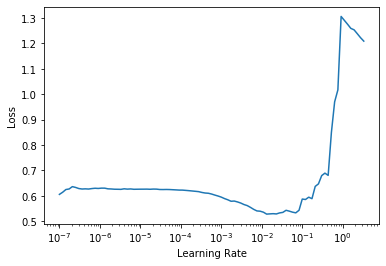

In [ ]:
learn.lr_find()

In [ ]:
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.373488,0.362226,0.841523,00:03
1,0.367182,0.354484,0.838759,00:03
2,0.368737,0.355205,0.834306,00:03



Can we speed this up a little? Yes we can! The more you can load into a batch, the faster you can process the data. This is a careful balance, for tabular data I go to a maximum of 4096 rows per batch if the dataset is large enough for a decent number of batches:

In [ ]:
dls = to.dataloaders(bs=1024)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.389950,0.407716,0.812500,00:00
1,0.366711,0.350281,0.839681,00:00
2,0.357688,0.355638,0.836763,00:00



We can see we fit very quickly, but it didn't fit quite as well (there is a trade-off):

In [ ]:
dls = to.dataloaders(bs=4096)
learn = tabular_learner(dls, [200,100], metrics=accuracy)
learn.fit(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.449081,0.503046,0.772267,00:00
1,0.407749,0.465814,0.758446,00:00
2,0.387042,0.445514,0.776720,00:00


## Inference

Now let's look at how we can perform inference. To do predictions we can use `fastai`'s in-house `learn.predict` for individual rows, and `get_preds` + `test_dl` for batches of predictions:

In [ ]:
row, cls, probs = learn.predict(df.iloc[0])

In [ ]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101320.00007,12.0,<50k


Now let's try `test_dl`. There's something special we can do here too:


In [ ]:
dl = learn.dls.test_dl(df.iloc[:100])

Let's look at a batch:

In [ ]:
dl.show_batch()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101320.000070,12.0,>=50k
1,Private,Masters,Divorced,Exec-managerial,Not-in-family,White,False,44.0,236745.999937,14.0,>=50k
2,Private,HS-grad,Divorced,#na#,Unmarried,Black,True,38.0,96185.001851,10.0,<50k
3,Self-emp-inc,Prof-school,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,False,38.0,112846.997614,15.0,>=50k
4,Self-emp-not-inc,7th-8th,Married-civ-spouse,Other-service,Wife,Black,True,42.0,82296.994924,10.0,<50k
5,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,False,20.0,63210.003417,9.0,<50k
6,Private,Some-college,Divorced,#na#,Other-relative,White,False,49.0,44434.000334,10.0,<50k
7,Private,11th,Married-civ-spouse,#na#,Husband,White,False,37.0,138939.999209,7.0,<50k
8,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,False,46.0,328215.996478,9.0,>=50k
9,Self-emp-inc,HS-grad,Married-civ-spouse,#na#,Husband,White,True,36.0,216711.000298,10.0,>=50k


We have our labels! It'll grab them if possible by default! 

What does that mean? Well, besides simply calling `get_preds`, we can also run `validate` to see how a model performs. This is nice as it can allow for efficient methods when calculating something like permutation importance:

In [ ]:
learn.validate(dl=dl)

(#2) [0.4870152175426483,0.7699999809265137]

We'll also show an example of `get_preds`:

In [ ]:
preds = learn.get_preds(dl=dl)

In [ ]:
preds[0][0]

tensor([0.5952, 0.4048])

What would happen if I accidently passed in an unlablled dataset to `learn.validate` though? Let's find out:

In [ ]:
df2 = df.iloc[:100].drop('salary', axis=1)
df2.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States


In [ ]:
dl = learn.dls.test_dl(df2)
learn.validate(dl=dl)

(#2) [None,None]

We can see it will simply just return `None`!